## Sign Language Detection

In this notebook, we explore the capability of detecting sign language characters from input images. This is the intermediate step between training the sign language detection model on an existing dataset and getting the model to work with live input images via a live camera. Below is a quick description of the iterative steps that we are taking to achieve our goal.

* MNIST Sign Language Data: We first want to build our sign language detection model such that it works on already-curated sign language images. These images are 28 pixels wide, and another 28 pixels tall (28 x 28).
* Pre-Captured Image Data (This Notebook): We then want to use our trained model to detect sign language in pre-captured images, taken with a camera. These images are not 28 x 28, so the goal of this step is to perform data pre-processing in order to format these input images in such a way that our model can use them.
* Live-Captured Image Data: Our final goal is to use our work to create a Streamlit application that is capable of taking images in real time, evaluating the sign language characters in those images by using our trained model.

In this notebook, we wish to prepare pre-captured images for model evaluation. In doing so, we will achieve the following goals:

* Use a YOLO object detection model to generate a rectangular bounding box around the hand in the sign language image, cropping the original image to that bounding box.
* "Blur" the resulting image using calculated strides in both the x and y directions to condense it to a size of 28 x 28, which is what the model expects.
* Convert the image to greyscale, as the model expects.
* Evaluate the image using the trained sign language model, hopefully resulting in correct classifications for images captured by a camera.

## Import Statements

First, we will import the necessary libraries for this task.

In [1]:
# deep learning libraries
from tensorflow import keras
import torch
import torchvision

# data manipulation libraries
import pandas as pd
import numpy as np

# plotting/display libraries
import skimage.measure
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# from IPython.display import Image
import IPython
from PIL import Image

In [2]:
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


## Testing the Sign Language Model

In this section, we will test our already-trained sign language model, `sign_language_model.keras`, on the already-curated MNIST sign language test data, just to ensure that the model can be loaded and evaluated properly.

In [3]:
# load the saved sign language model
model_sign = keras.models.load_model('models/sign_language_model.keras')

In [50]:
# load the test data
test = pd.read_csv('data/sign_mnist_test.csv')
test.head()

,label,pixel1,pixel2,pixel3,pixel4,...,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,...,96,106,112,120,107
1,5,126,128,131,132,...,184,184,184,182,180
2,10,85,88,92,96,...,227,226,225,224,222
3,0,203,205,207,206,...,236,230,240,253,255
4,3,188,191,193,195,...,46,49,46,46,53


In [4]:
# store the index-to-letter transformation
index_to_letter = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'k', 10: 'l', 11: 'm', 12: 'n', 13: 'o', 14: 'p', 15: 'q', 16: 'r', 17: 's', 18: 't', 19: 'u', 20: 'v', 21: 'w', 22: 'x', 23: 'y'}

In [52]:
# Check shape and resize
print("Raw Data Shape:")
print("Test Shape:", test.shape)

# shift labels down
test["label"][test["label"] >= 10] = test["label"] -1

# create data and label sets for testing
test_data = test.drop("label", axis = 1)
test_labels = test['label']
test_data = np.array(test_data)

# normalize the data so the pixels range from [0-1]
test_data = test_data / 255

# print the shape of the data and label arrays
print("\nAfter Splitting into X and y:")
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)


# reshape images to 28x28 for CNN input
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

# print the data after reshaping to 28x28
print("\nAfter Reshaping Data:")
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

Raw Data Shape:
Test Shape: (7172, 785)

After Splitting into X and y:
Test Data Shape: (7172, 784)
Test Labels Shape: (7172,)

After Reshaping Data:
Test Data Shape: (7172, 28, 28, 1)
Test Labels Shape: (7172,)


In [7]:
# make predictions using the loaded model
predictions = model_sign.predict(test_data, verbose = 0)
predicted_labels = np.argmax(predictions, axis = 1)

In [8]:
# report a few predictions with their true labels
for p, l in zip(predicted_labels[:10], test_labels[:10]):
  print(f'Predicted: {p}, True: {l}')

Predicted: 6, True: 6
Predicted: 5, True: 5
Predicted: 9, True: 9
Predicted: 0, True: 0
Predicted: 3, True: 3
Predicted: 20, True: 20
Predicted: 9, True: 9
Predicted: 13, True: 13
Predicted: 3, True: 3
Predicted: 7, True: 7


The model has been loaded properly and seems to be predicting well!

## YOLO Object Detection Model

In this section, we test the pre-trained YOLO model to see if we can reduce our input images to the appropriate size and format for use in our sign language detection model.

In [ ]:
# install ultralytics as the YOLO documentation states
!pip install -U ultralytics

In [ ]:
# load the YOLO model
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained = True)

In [27]:
# remove the 'runs' folder because the YOLO model will save there
!rm -rf runs/

In [28]:
# obtain results and save them
images = ['img/hand2_a.jpeg', 'img/hand2_c.jpeg']

results = model_yolo(images)
results.save()

Saved 2 images to runs/detect/exp


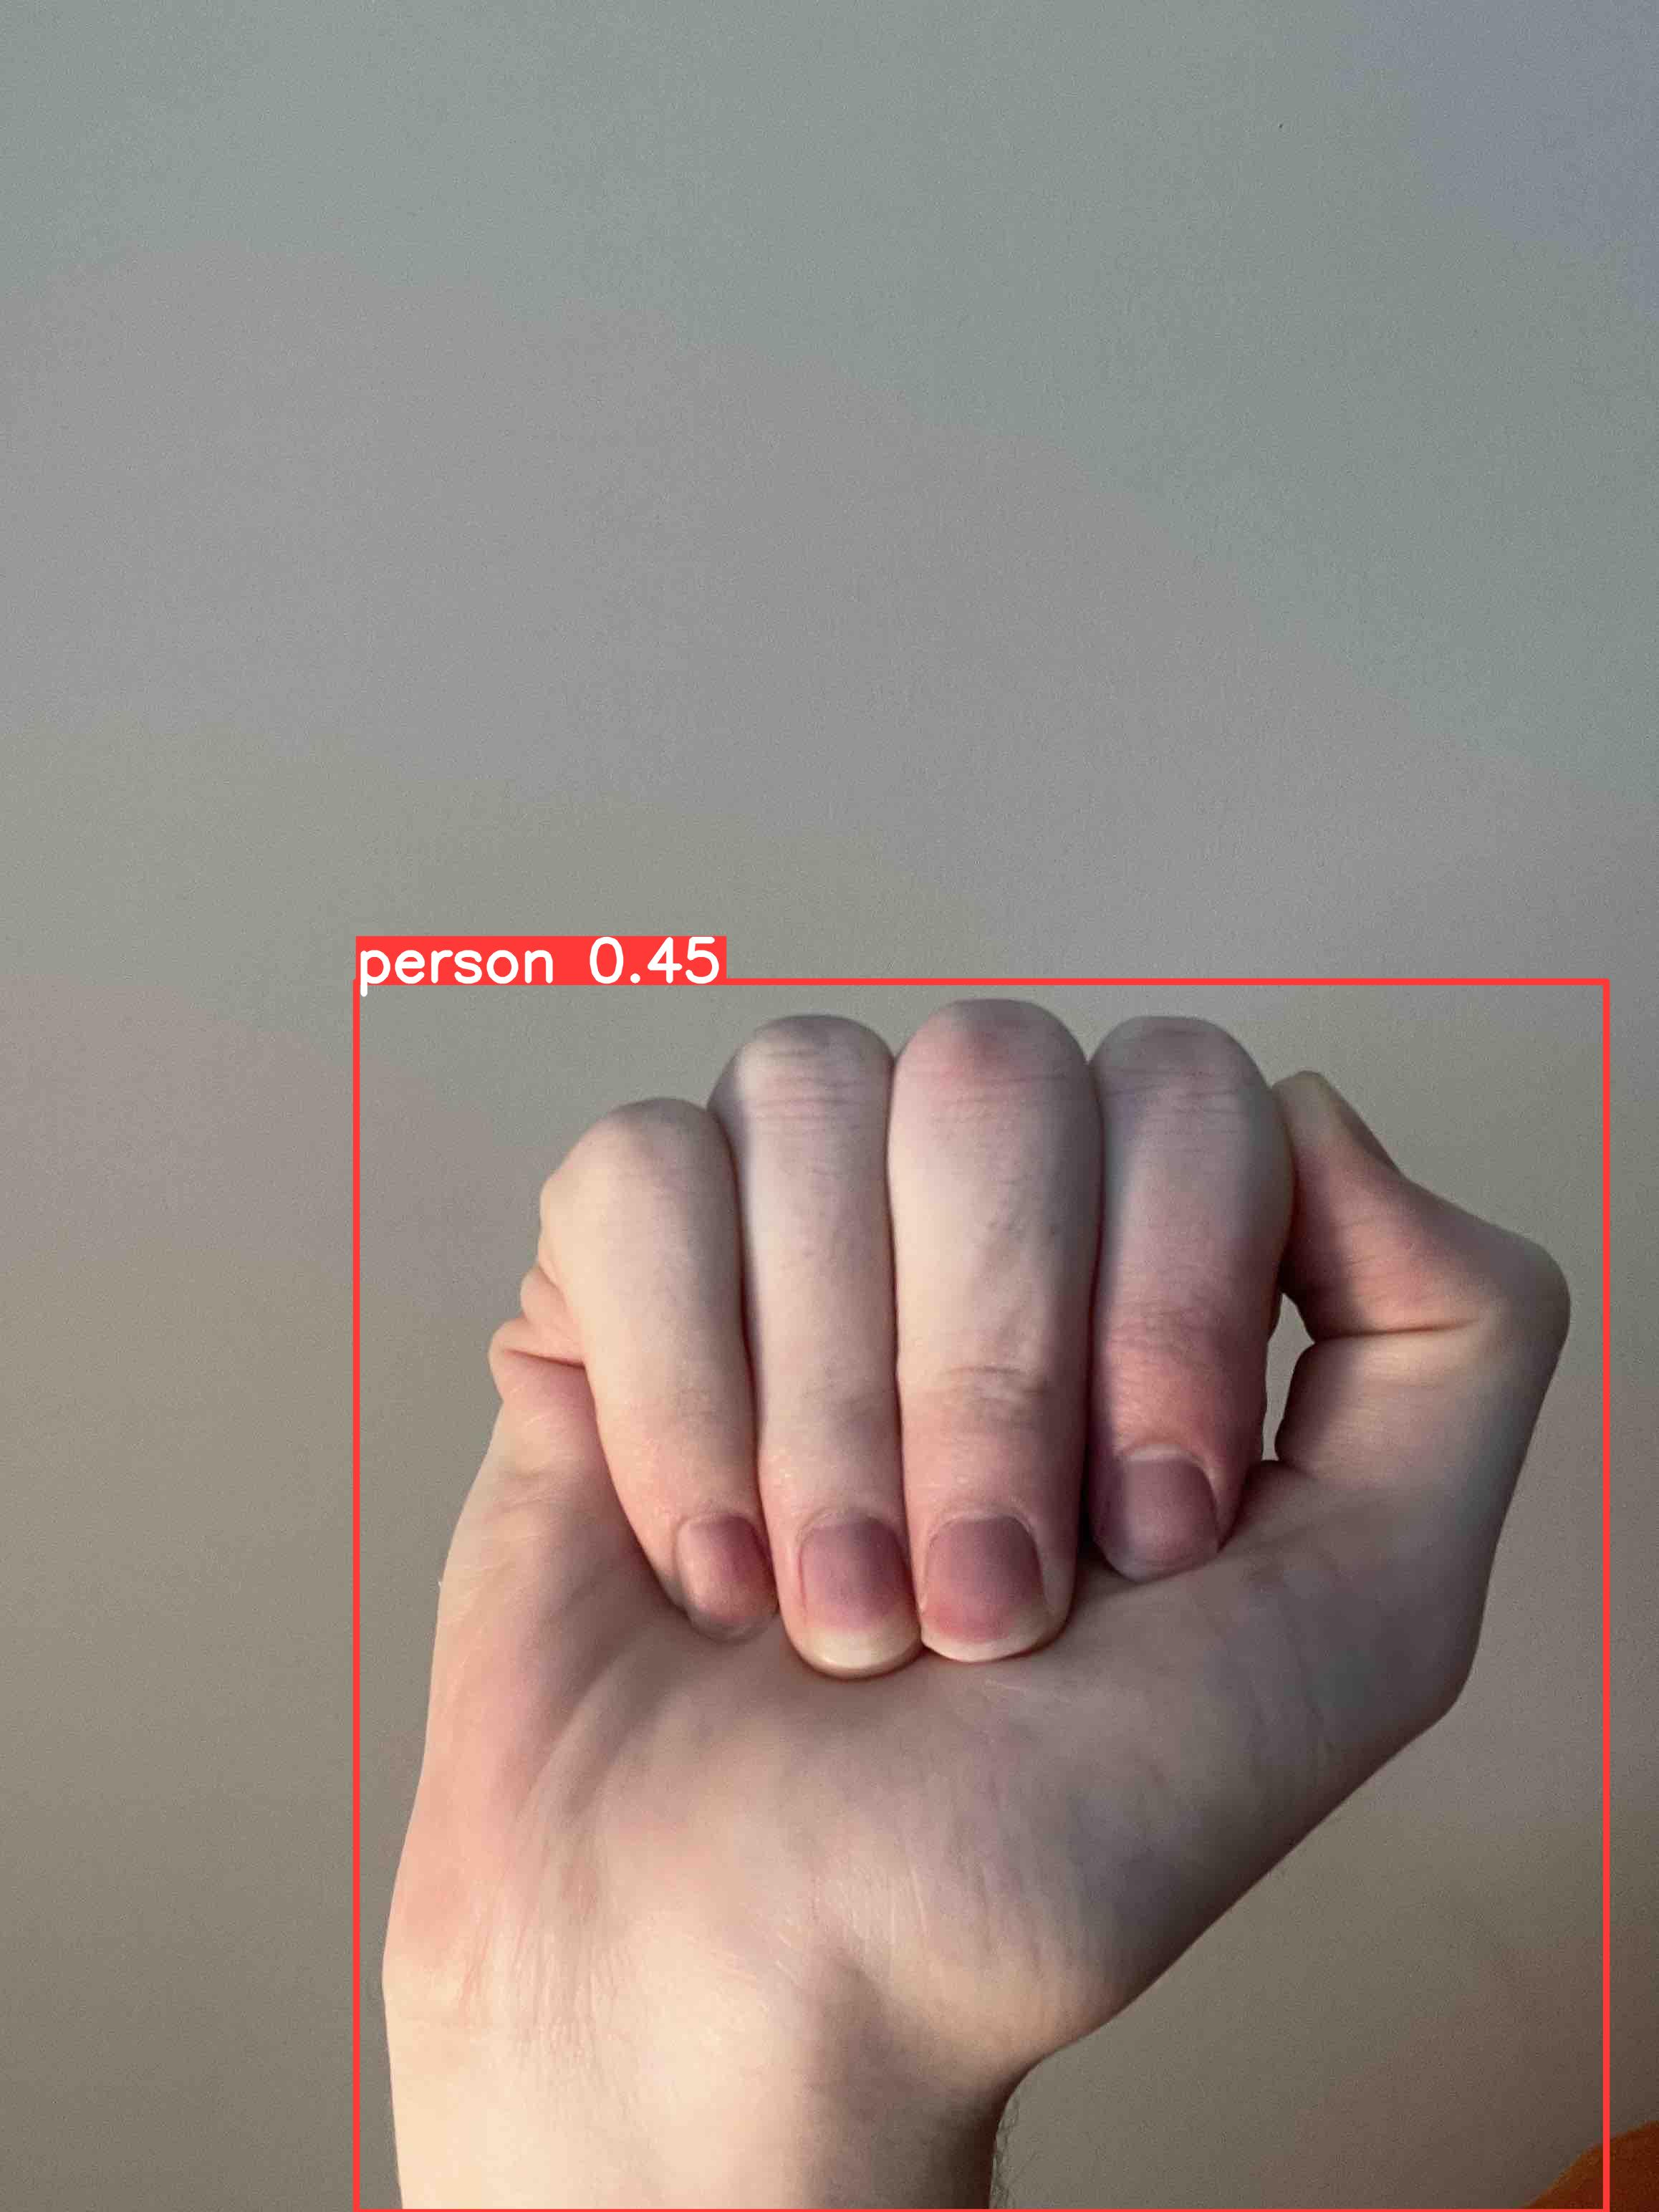

In [29]:
# first image
IPython.display.Image('runs/detect/exp/hand2_a.jpg', width = 300)

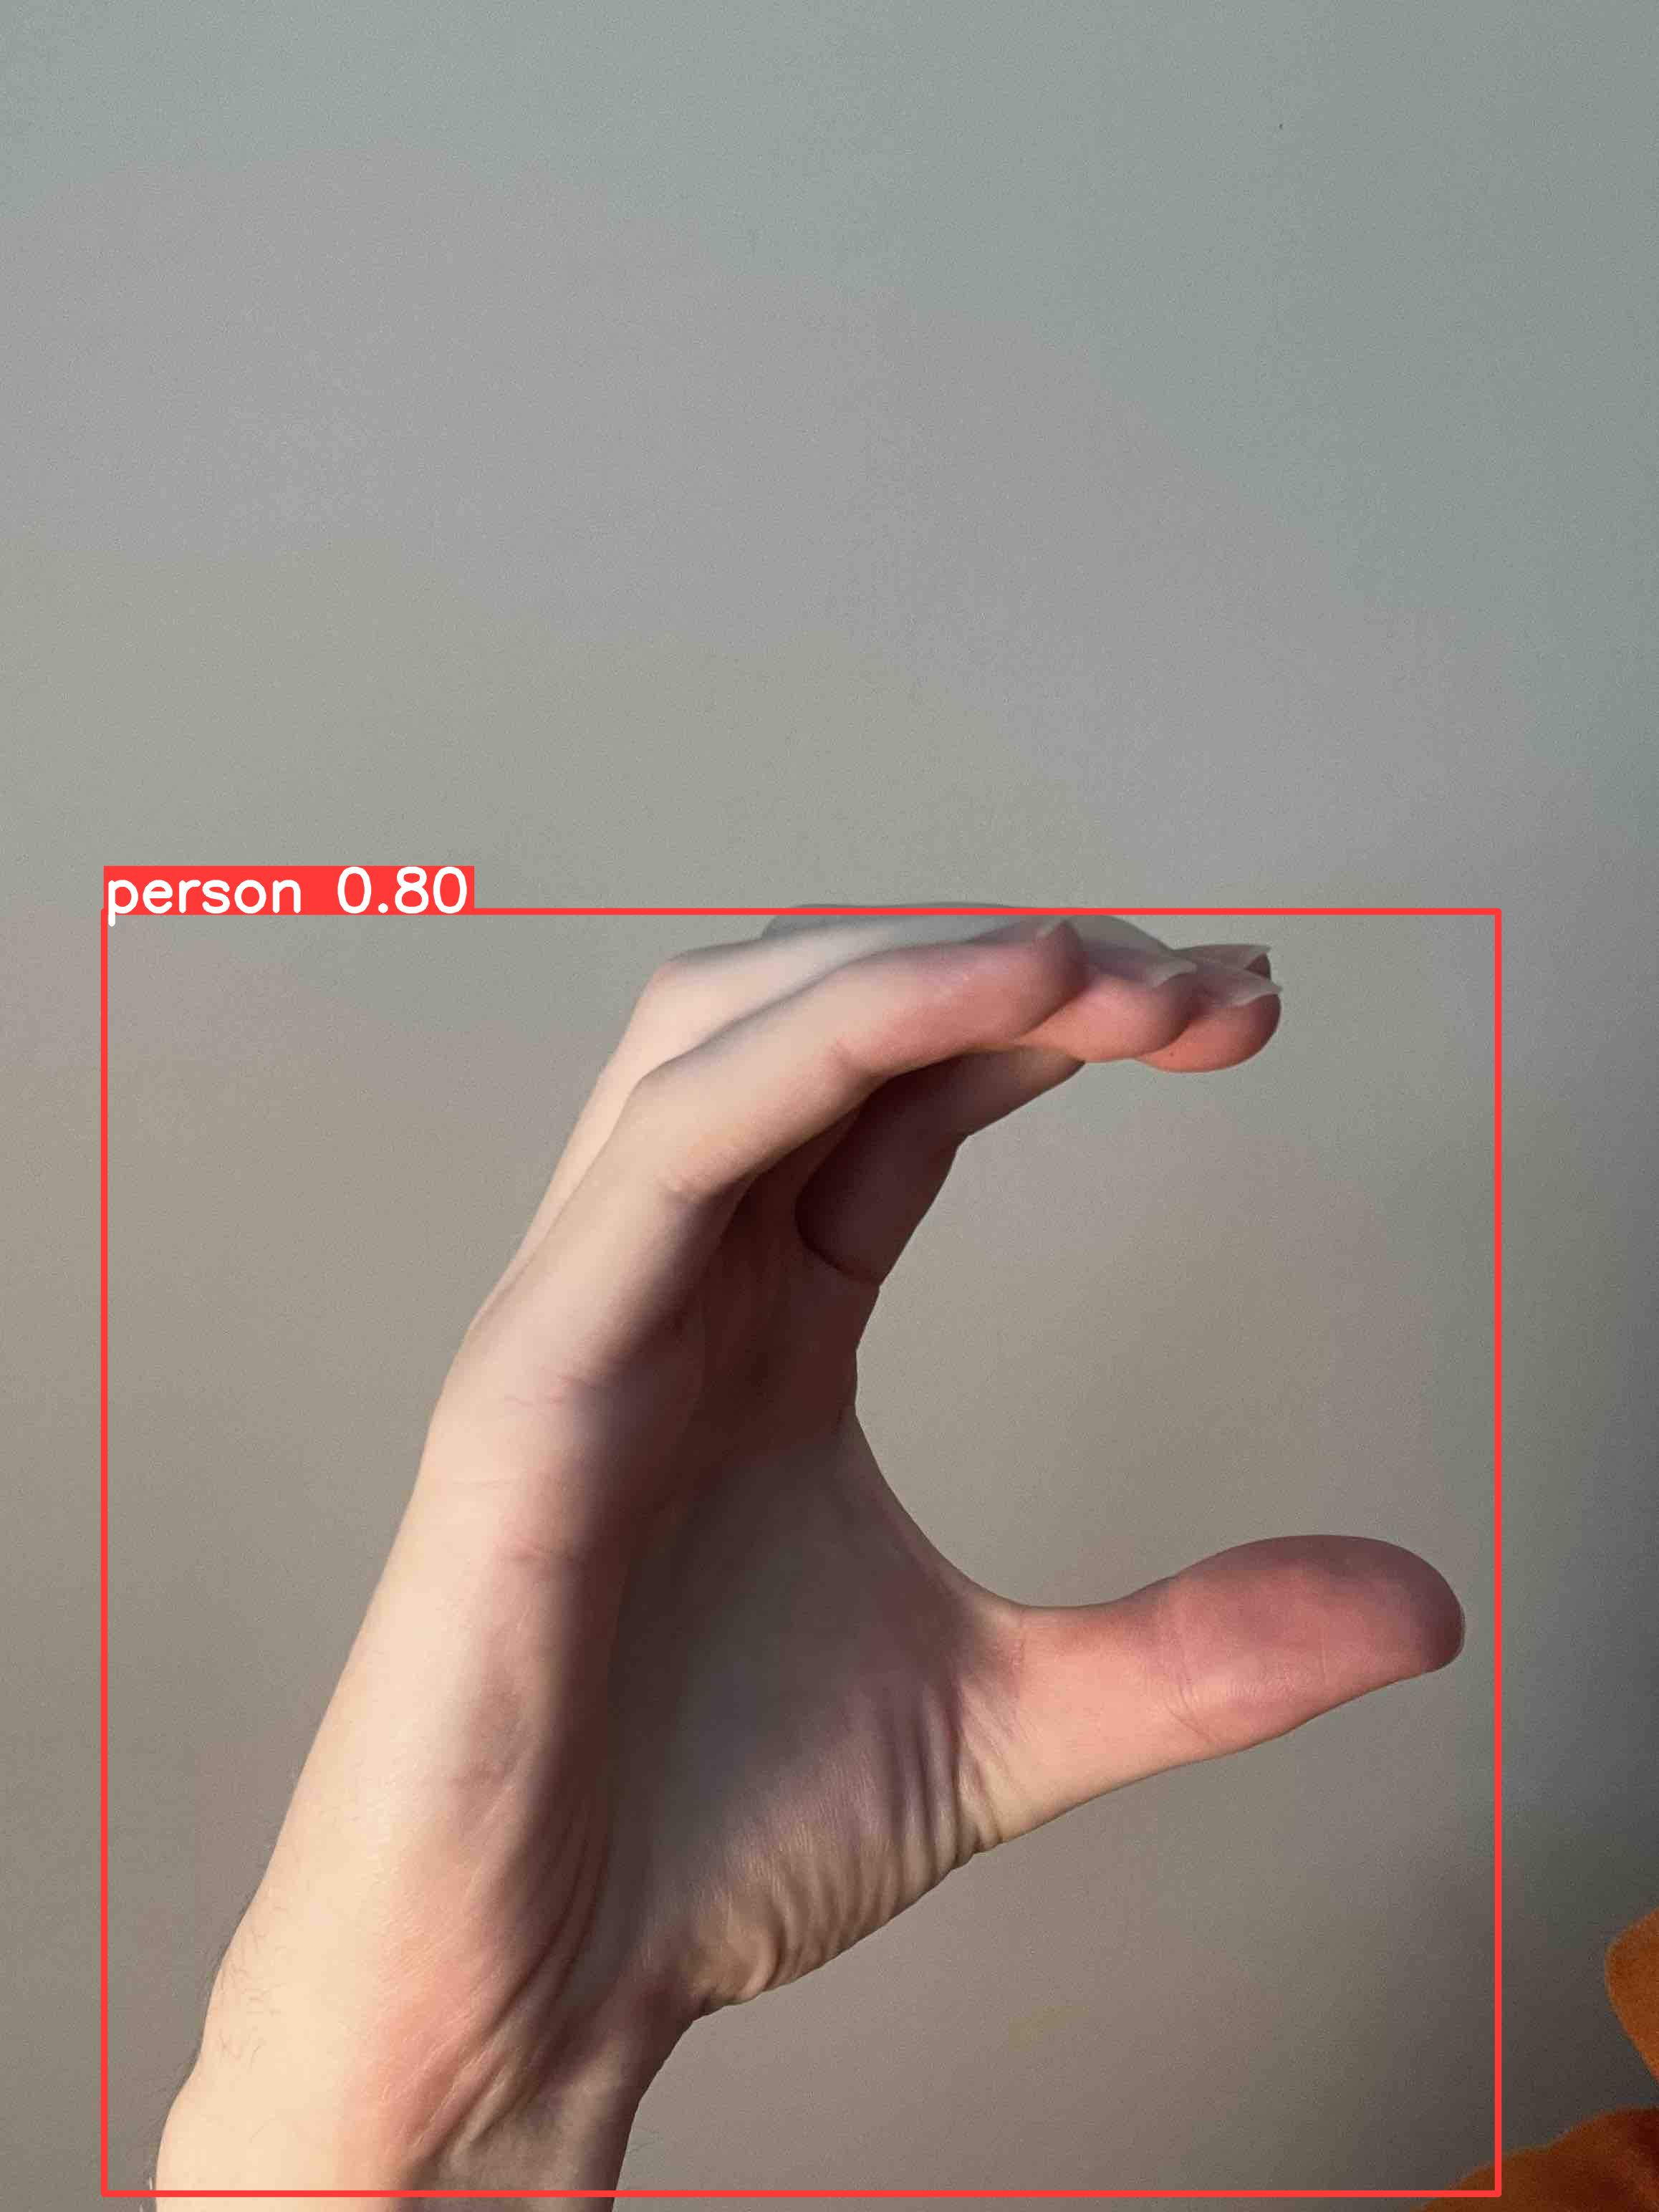

In [30]:
# second image
IPython.display.Image('runs/detect/exp/hand2_c.jpg', width = 300)

### Testing Hand 1

Here, we test our pipeline on our first hand example.

In [10]:
# read the image into numpy
hand1 = mpimg.imread('img/hand2_a.jpeg')

In [11]:
# store the bounding box for the hand, as detected by the YOLO model
result = results.pandas().xyxy[0].iloc[0]
xmin, xmax, ymin, ymax = int(result['xmin']), int(result['xmax']), int(result['ymin']), int(result['ymax'])
xmin, xmax, ymin, ymax

(497, 2242, 1370, 3088)

In [12]:
# crop to bounding box
hand1 = hand1[ymin:ymax, xmin:xmax, :]

# make greyscale
hand1 = hand1.mean(axis = 2, keepdims = True)

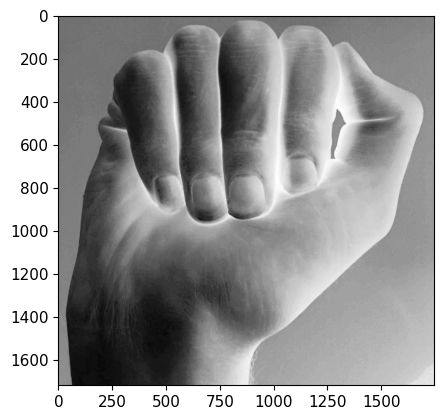

In [14]:
%matplotlib inline
plt.imshow(hand1, cmap = 'Greys')

In [15]:
# calculate the step size for pixelation
step_size_i = hand1.shape[0] // 28
step_size_j = hand1.shape[1] // 28

# pixelate the image
hand1small = skimage.measure.block_reduce(hand1, (step_size_i, step_size_j, 1), np.mean)

# if the shape is not divisible by 28, we have dimensions of size 29
hand1small = hand1small[:28, :28, :]

# to send to model, we need the batch dimension as well
hand1small = np.expand_dims(hand1small, 0)

print(hand1small.shape)

(1, 28, 28, 1)


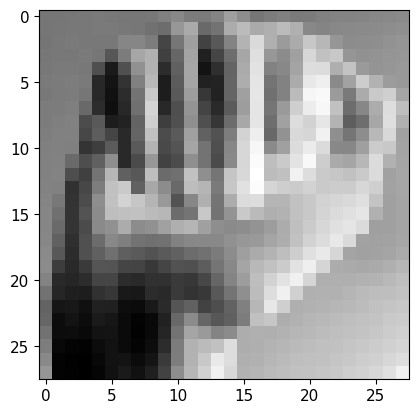

In [16]:
%matplotlib inline
plt.imshow(hand1small.reshape(28, 28, -1), cmap = 'Greys')

In [17]:
# predict using the sign language model
prediction = model_sign.predict(hand1small, verbose = 0)
predicted_label = np.argmax(prediction, axis = 1)

In [19]:
print(f'Predicted: {index_to_letter[predicted_label[0]]}, True: a')

Predicted: w, True: a


In this case, our model predicted 'w', when the correct sign was 'a'.

### Testing Hand 2

Here, we test our pipeline on our second hand example.

In [31]:
# read the image into numpy
hand2 = mpimg.imread('img/hand2_c.jpeg')

In [32]:
# store the bounding box for the hand, as detected by the YOLO model
result = results.pandas().xyxy[1].iloc[0]
xmin, xmax, ymin, ymax = int(result['xmin']), int(result['xmax']), int(result['ymin']), int(result['ymax'])
xmin, xmax, ymin, ymax

(145, 2091, 1272, 3062)

In [33]:
# crop to bounding box
hand2 = hand2[ymin:ymax, xmin:xmax, :]

# make greyscale
hand2 = hand2.mean(axis = 2)

# expand dim to have (m, n, 1) shape
hand2 = np.expand_dims(hand2, axis = 2)

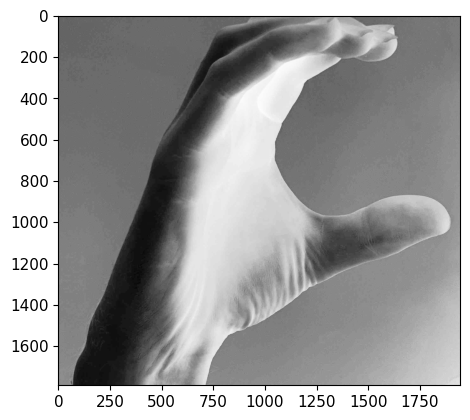

In [36]:
%matplotlib inline
plt.imshow(hand2, cmap = 'Greys')

In [34]:
# calculate the step size for pixelation
step_size_i = hand2.shape[0] // 28
step_size_j = hand2.shape[1] // 28

# pixelate the image
hand2small = skimage.measure.block_reduce(hand2, (step_size_i, step_size_j, 1), np.mean)

# if the shape is not divisible by 28, we have dimensions of size 29
hand2small = hand2small[:28, :28, :]

# to send to model, we need the batch dimension as well
hand2small = np.expand_dims(hand2small, 0)

print(hand2small.shape)

(1, 28, 28, 1)


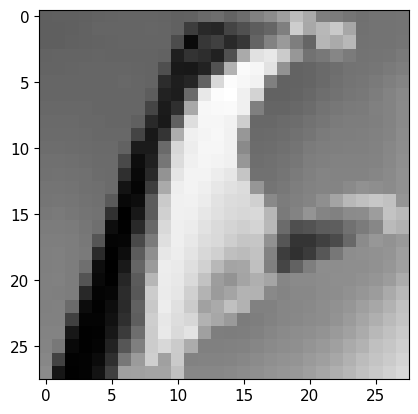

In [35]:
%matplotlib inline
plt.imshow(hand2small.reshape(28, 28, -1), cmap = 'Greys')

In [37]:
# predict using the sign language model
prediction = model_sign.predict(hand2small, verbose = 0)
predicted_label = np.argmax(prediction, axis = 1)

In [38]:
print(f'Predicted: {index_to_letter[predicted_label[0]]}, True: c')

Predicted: c, True: c


In this case, our model predicted 'c', which is the correct sign!

### Testing All Hands

Here, we test our pipeline on all our hand images.

In [39]:
!rm -rf runs/

In [40]:
# obtain results and save them
my_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h' ,'i', 'k', 'l', 'm',
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']
images = [f'img/hand2_{letter}.jpeg' for letter in my_letters]

results = model_yolo(images)
results.save()

Saved 24 images to runs/detect/exp


In [41]:
true_letters = my_letters # ['w', 'v', 'h', 'l']
saved_images, predicted_labels = [], []

for idx, value in enumerate(my_letters):

    # read the image into numpy
    hand = mpimg.imread(f'img/hand2_{str(value)}.jpeg')

    # store the bounding box for the hand, as detected by the YOLO model
    try:
        # if mulitple boxes, take the largest one
        result = results.pandas().xyxy[idx]
        result['area'] = (result['xmax'] - result['xmin']) * (result['ymax'] - result['ymin'])
        result = result.sort_values(by = ['area'], ascending = False)
        result = result.iloc[0]
        xmin, xmax, ymin, ymax = int(result['xmin']), int(result['xmax']), int(result['ymin']), int(result['ymax'])
    except:
        print(f'Result not found for letter {value}, using entire image')
        xmin, xmax, ymin, ymax = 0, hand.shape[1], 0, hand.shape[0]

    # add 100-pixel buffers to the bounding box
    xbuffer, ybuffer = 100, 100
    xmin = max(xmin - xbuffer, 0)
    ymin = max(ymin - ybuffer, 0)
    xmax = min(xmax + xbuffer, hand.shape[1])
    ymax = min(ymax + ybuffer, hand.shape[0])

    # crop to bounding box
    hand = hand[ymin:ymax, xmin:xmax, :]

    # make greyscale
    hand = hand.mean(axis = 2, keepdims = True)

    # convert [0, 255] color scale to [0, 1]
    hand = hand / 255.0

    # calculate the step size for pixelation
    step_size_i = hand.shape[0] // 28
    step_size_j = hand.shape[1] // 28

    # pixelate the image
    handsmall = skimage.measure.block_reduce(hand, (step_size_i, step_size_j, 1), np.mean)

    # if the shape is not divisible by 28, we have dimensions of size 29
    handsmall = handsmall[:28, :28, :]

    # to send to model, we need the batch dimension as well
    handsmall = np.expand_dims(handsmall, 0)

    # save the numpy matrix for visualization later
    saved_images.append(handsmall)

    # predict using the sign language model
    prediction = model_sign.predict(handsmall, verbose = 0)
    predicted_label = np.argmax(prediction, axis = 1)

    predicted_labels.append(predicted_label[0])

    # %matplotlib inline
    # plt.imshow(handsmall.reshape(28, 28, -1))

    print(f'True: {true_letters[idx]}, Predicted: {index_to_letter[predicted_label[0]]}') # w v h l

True: a, Predicted: a
True: b, Predicted: b
True: c, Predicted: c
True: d, Predicted: i
True: e, Predicted: e
True: f, Predicted: f
True: g, Predicted: x
True: h, Predicted: x
True: i, Predicted: y
True: k, Predicted: s
True: l, Predicted: d
True: m, Predicted: n
True: n, Predicted: s
True: o, Predicted: o
True: p, Predicted: h
True: q, Predicted: q
True: r, Predicted: n
True: s, Predicted: s
True: t, Predicted: t
True: u, Predicted: d
True: v, Predicted: v
True: w, Predicted: w
True: x, Predicted: o
True: y, Predicted: i


In [44]:
# compute and display the accuracy on our 24 hands
count, total = 0, 0
for x, y in zip(true_letters, predicted_labels):
    if x == index_to_letter[y]:
        count += 1
    total += 1

print(f'Accuracy: ({count}/{total}) = {count / total}')

Accuracy: (11/24) = 0.4583333333333333


### Displaying Results

Here, we display the results of our pipeline on our camera-taken images.

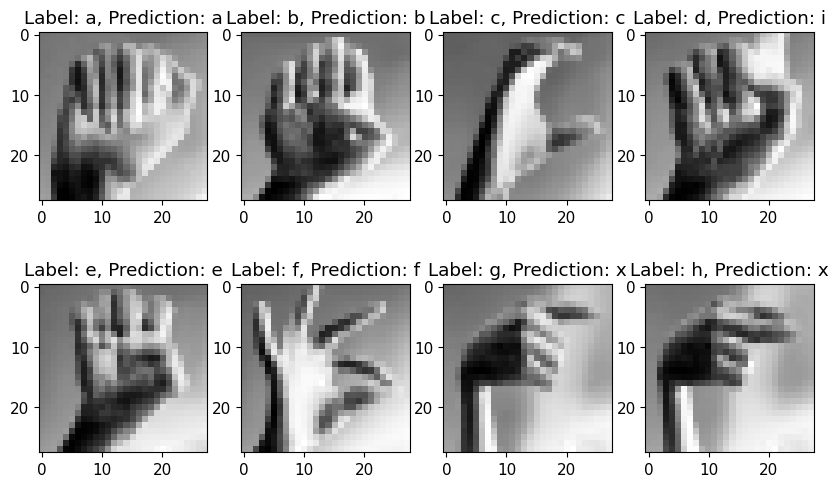

In [46]:
%matplotlib inline

# display the first eight hands
fig, ax = plt.subplots(2, 4, figsize = (10, 6))
ax = ax.flatten()
for i in range(8):
    ax[i].imshow(saved_images[i].reshape(28, 28, -1), cmap = 'Greys')
    ax[i].set_title(f'Label: {true_letters[i]}, Prediction: {index_to_letter[predicted_labels[i]]}')
plt.show()

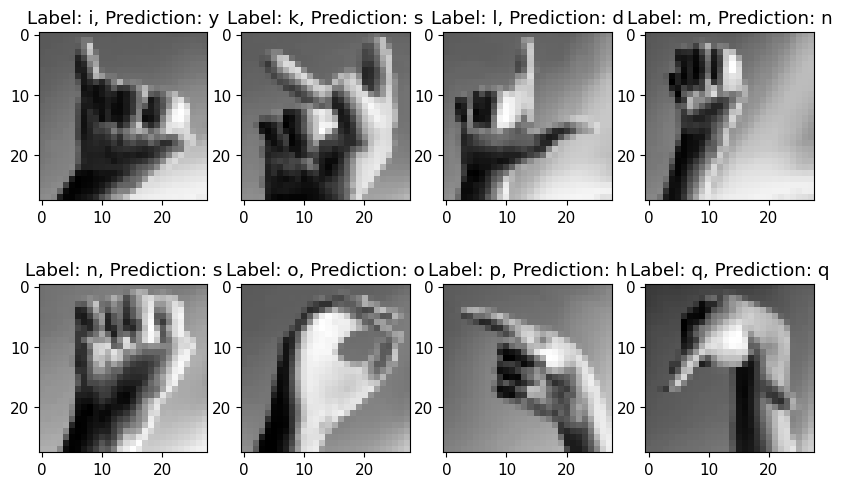

In [47]:
%matplotlib inline

# display the next eight hands
fig, ax = plt.subplots(2, 4, figsize = (10, 6))
ax = ax.flatten()
for i in range(8, 16):
    ax[i-8].imshow(saved_images[i].reshape(28, 28, -1), cmap = 'Greys')
    ax[i-8].set_title(f'Label: {true_letters[i]}, Prediction: {index_to_letter[predicted_labels[i]]}')
plt.show()

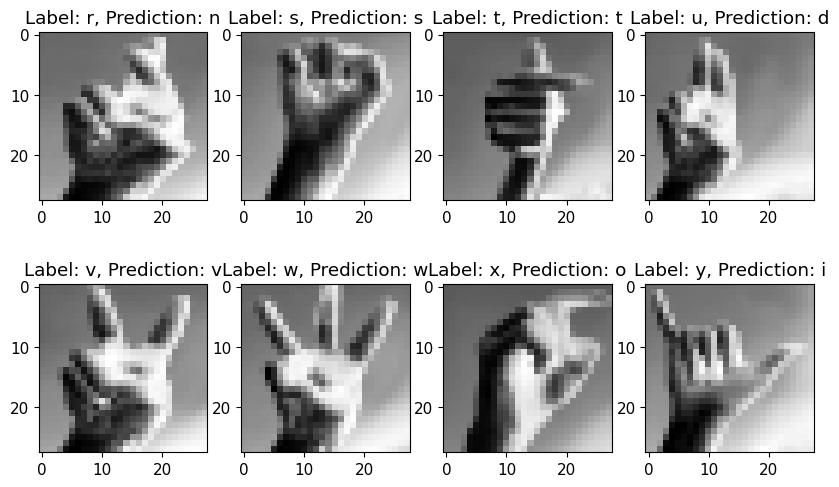

In [48]:
%matplotlib inline

# display the last eight hands
fig, ax = plt.subplots(2, 4, figsize = (10, 6))
ax = ax.flatten()
for i in range(16, 24):
    ax[i-16].imshow(saved_images[i].reshape(28, 28, -1), cmap = 'Greys')
    ax[i-16].set_title(f'Label: {true_letters[i]}, Prediction: {index_to_letter[predicted_labels[i]]}')
plt.show()

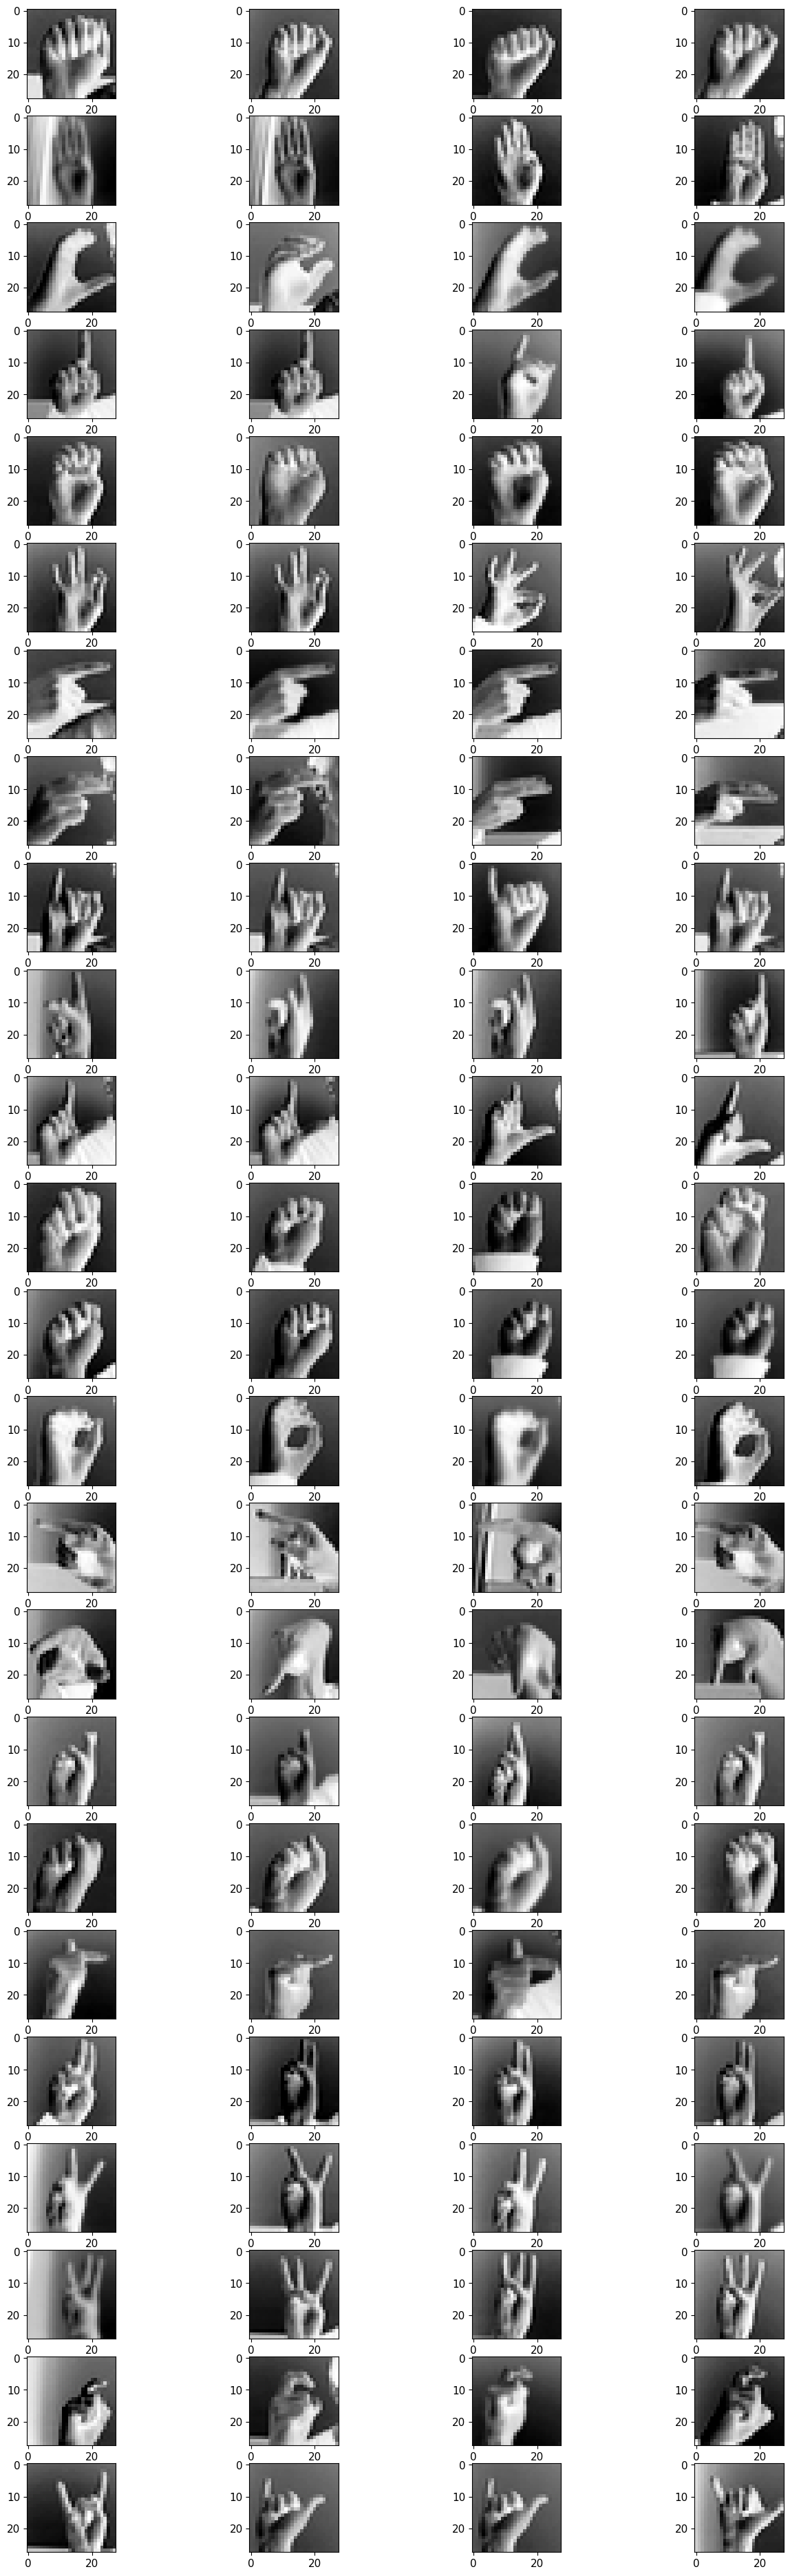

In [53]:
# %matplotlib inline

# display four examples of each of the 24 letters in the test data
fig, ax = plt.subplots(24, 4, figsize = (16, 48))
ax = ax.flatten()

for j in range(24):
    mydata = test_data[test_labels == j]
    for i in range(4):
        ax[j*4 + i].imshow(mydata[i].reshape(28, 28, -1), cmap = 'Greys')